# STOCK TRADING

Stock trading agent based on PPO

* Using state as:
    * Close (detrend)
    * Open (detrend)
    * High (detrend)
    * Low (detrend)
    * Predicted (detrend)
    * Holdings
    * Cash
    * Port value
    * Avg price paid

In [1]:
!pip install opencv-python

     |████████████████████████████████| 49.9 MB 4.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import json
import tensorflow as tf

from PPO.ppo import PPO

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from core.market_env_v0 import MarketEnvironmentV0
from utils.networks import get_session

In [6]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Load data

In [9]:
x_train = np.loadtxt('data/EURUSD-1D-agent-train-detrend.csv', delimiter=",")
x_train_undo_detrend = np.loadtxt('data/EURUSD-1D-agent-train.csv', delimiter=",")

## Hyper parameters

In [57]:
### MODEL HYPERPARAMETERS
seq_len = 100
num_cols = 9 # OHLC and others

# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]
state_size = (5, 1) # (close, open, high, low, predicted of next candle)
action_size = 3              # 3 possible actions: sit, buy, sell

# Learning Hyper parameters
learning_rate =  1e-5
reward_function =  'SimpleProfit' # policy function

### TRAINING HYPERPARAMETERS
total_episodes = 5000
batch_size = 1024

# Exploration parameters for epsilon greedy strategy
explore_start = 0.6            # exploration probability at start
explore_stop = 0.1            # minimum exploration probability 
decay_rate = 0.01            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.999               # Discounting rate


### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 20000          # Number of experiences the Memory can keep

### PPO Params
profit_window_size = 10
close_col = 0
buffer_size = 1024
epochs = 10
initial_cash = 5.0
loss_clipping = 0.2
noise = 1.0
entropy_loss = 5e-3

gpu = True
gather_stats = True
env_name = 'Market'
type = 'PPO'
consecutive_frames = 4


### Env penalties
large_holdings_penalty = 0
lost_all_cash_penalty = -1e2
inaction_penalty = -1e-4


### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## Init logs

In [58]:
tensorboard_logs = type + "/tensorboard_" + env_name + "_v0.2"

In [59]:
!mkdir $tensorboard_logs

# Clear any logs from previous runs
import shutil
shutil.rmtree(tensorboard_logs)

mkdir: cannot create directory ‘PPO/tensorboard_Market_v0.2’: File exists


In [60]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(tensorboard_logs)

## Seeing data

No handles with labels found to put in legend.


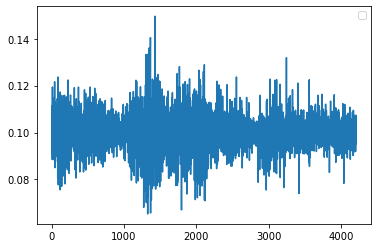

In [61]:
import matplotlib.pyplot as plt

fig1 = plt.figure(facecolor='white')
ax1 = fig1.add_subplot(111)
plt.plot(x_train[:, 0])
plt.legend()
plt.show()

## Setting up the algo

In [62]:
# Environment Initialization
env = MarketEnvironmentV0(x_train, possible_actions, state_size, 
                        start_index=300,
                        end_index=405,
                        initial_cash=initial_cash,
                        close_col=close_col, 
                        undo_detrend=x_train_undo_detrend, 
                        reward_function=reward_function, 
                        profit_window_size=profit_window_size, 
                        inaction_penalty=inaction_penalty,
                        large_holdings_penalty=large_holdings_penalty)
env.reset()
state_dim = env.get_state_size()[0]
action_dim = env.get_action_size()

SimpleProfit


In [63]:
layers = [
			{
				"type": "dense",
				"neurons": 32,
				"activation": "tanh",
				"is_input": True
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 32
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 8
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 32
			},
			{
				"type": "dense",
				"activation": "tanh",
				"neurons": 8
			},
			{
				"type": "dense",
				"is_output": True,
				"activation": "softmax"
			}
		]

In [64]:
algo = PPO(action_dim, state_dim, consecutive_frames, 
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_35 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 264       
_________________________________________________________________
actor_output (Dense)         (None, 3)                 27        
Total para

## Training

In [65]:
rewards, actor_losses, critic_losses = algo.train(env, summary_writer, debug=False, 
                    batch_size=batch_size, buffer_size=buffer_size, epochs=epochs, nb_episodes=total_episodes)

Score per bash:   0%|          | 0/5000 [00:00<?, ? episodes/s]

--------------------------------------------------
Traning with parameters:
	- learning_rate:  1e-05
	- batch_size:  1024
	- buffer_size:  1024
	- reward function:  <core.reward_functions.SimpleProfit object at 0x7f0e3019efd0>
	- epochs:  10
	- loss_clipping:  0.2
	- noise:  1.0
	- entropy_loss:  0.005
	- initial cash:  5.0
	- profit_window_size:  10
	- inaction_penalty:  -0.0001
--------------------------------------------------


Score per bash: -37.598465726162054: 100%|█████████▉| 4999/5000 [08:06<00:00, 10.28 episodes/s]


In [69]:
rewards = algo.batch_rewards

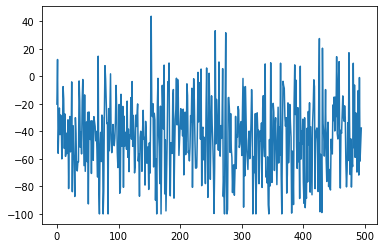

In [70]:
import matplotlib.pyplot as plt
plt.plot(np.array(rewards).clip(-1e2,1e4))
plt.show()

In [68]:
import datetime
now = datetime.datetime.now().strftime("%S-%M-%H_%d-%m-%Y")
weights_filename = "saved_models/PPO_" + now + "_"
algo.save_weights(weights_filename)

## TEsting

In [74]:
args = {
    'x': x_train, 
    'actions': possible_actions, 
    'state_size': state_size, 
    'start_index': 0,
    'end_index': 5000,
    'initial_cash': initial_cash,
    'close_col': close_col, 
    'undo_detrend': x_train_undo_detrend, 
    'reward_function': reward_function, 
    'profit_window_size': profit_window_size, 
    'inaction_penalty': inaction_penalty,
    'large_holdings_penalty': large_holdings_penalty
}
env = MarketEnvironmentV0(**args)

SimpleProfit


In [75]:
algo = PPO(action_dim, state_dim, consecutive_frames, is_eval=True,
           lr=learning_rate, gamma=gamma, layers=layers,
          loss_clipping=loss_clipping, noise=noise, entropy_loss=entropy_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
actor_input (Dense)          (None, 32)                192       
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_43 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 264       
_________________________________________________________________
actor_output (Dense)         (None, 3)                 27        
Total para

In [51]:
weights_filename

'saved_models/PPO_58-05-22_11-09-2021_'

In [77]:
algo.load_weights(
    "saved_models/PPO_11-17-22_11-09-2021__LR_1e-05_actor.h5", 
    "saved_models/PPO_11-17-22_11-09-2021__LR_1e-05_critic.h5"
)

In [78]:
def buy():
    states_sell = []
    states_buy = []
    close = []
    
    observation = env.reset()
    done = False
    t = 0 

    while not done:
        close.append(env.get_last_close())
        action = algo.policy_action(np.array(observation))
        if action == 1: states_buy.append(t)
        if action == 2: states_sell.append(t)
            
        observation, r, done, _ = env.step(action)
        
        t += 1
        
    info = env.get_info()
    return close, states_buy, states_sell, float(info['total_profit']), float(info['cash_profit'])

In [79]:
close, states_buy, states_sell, total_gains, invest = buy()

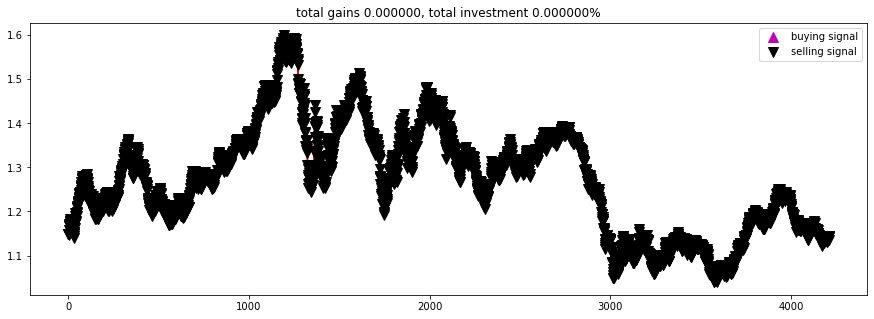

In [80]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()